##### Imports #####

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plots
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score # Split
from sklearn.linear_model import LogisticRegression #Baseline model (Logistic regression)
from sklearn import metrics #Asses model
import copy #For deepcopy
import seaborn as sns # confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler # Scaler
from sklearn.neural_network import MLPClassifier # Nural network

In [27]:
# Import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

##### Data overview #####

In [28]:
print(train.head())
print()
print(train.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


We see missing values in keyword and location.

In [29]:
missing_values_count = train.isnull().sum()
print(missing_values_count)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


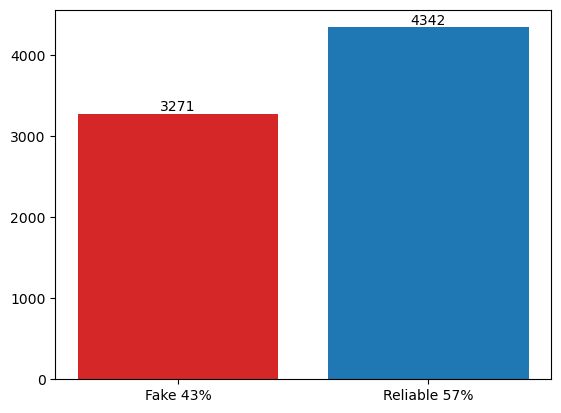

In [30]:
def balanceCheck():
    ones, zeros = 0, 0
    for value in train['target']:
        if value == 1:
            ones += 1
        elif value == 0:
            zeros += 1
    total = ones + zeros
    percentOnes = round(ones/total * 100)
    percentZeros = round(zeros/total * 100)
    #Plot
    fig, ax = plt.subplots()
    labels = ['Fake ' + str(percentOnes) + '%', 'Reliable ' + str(percentZeros) + '%']
    size = [ones, zeros]
    bar_colors = ['tab:red', 'tab:blue']
    bar_container = ax.bar(labels, size)
    ax.bar_label(bar_container)

    ax.bar(labels, size, label=labels, color=bar_colors)
balanceCheck()

In [31]:
for i in range(0, 10):
    print(train['text'][i], '\n')

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

Forest fire near La Ronge Sask. Canada 

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 

13,000 people receive #wildfires evacuation orders in California  

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 

#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas 

I'm on top of the hill and I can see a fire in the woods... 

There's an emergency evacuation happening now in the building across the street 

I'm afraid that the tornado is coming to our area... 



##### Preprocessing #####

In [32]:
train['keyword'] = train['keyword'].apply(lambda x: str(x))
train['location'] = train['location'].apply(lambda x: str(x))
print(train['keyword'].unique()[:10])

['nan' 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon']


In [33]:
import re
import nltk
import string   
import itertools

sno = nltk.stem.SnowballStemmer('english')

# Clean text
def cleanText(input):
    tweet = str(input)
    tweet = tweet.lower()
    #Regular expressions
    tweet = re.sub(r'https?:\/\/.\S+', "", tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'(\b\d+.\b\d+)|(\b\d+\b)', 'NUM', tweet) 
    tweet = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", tweet) 

    #Stop words
    stop = nltk.corpus.stopwords.words('english')
    tweet = ' '.join([word for word in tweet.split() if word not in stop])
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))

    #Tokenize
    tweet = nltk.word_tokenize(tweet)
    stemmed_tweets = []
    for word in tweet:
        stemmed_tweets.append(sno.stem(word))
    stemmed_tweets = ' '.join(stemmed_tweets)
    return stemmed_tweets

def cleanKeyword(input):
    tweet = str(input)
    tweet = re.sub(r'%20', " ", tweet)
    return tweet


train['text'] = train['text'].apply(cleanText)
test['text'] = test['text'].apply(cleanText)
train['keyword'] = train['keyword'].apply(cleanKeyword)
test['keyword'] = test['keyword'].apply(cleanKeyword)
 

In [34]:
for elm in train['text'][0:10]:
    print (elm)

print("\nUnique strings in keywords: ")
print(train['keyword'].unique()[:10])

deed reason earthquak may allah forgiv us
forest fire near la rong sask canada
resid ask shelter place notifi offic evacu shelter place order expect
num peopl receiv wildfir evacu order california
got sent photo rubi alaska smoke wildfir pour school
rockyfir updat california hwi num close direct due lake counti fire cafir wildfir
flood disast heavi rain caus flash flood street manitou colorado spring area
im top hill see fire wood
there emerg evacu happen build across street
im afraid tornado come area

Unique strings in keywords: 
['nan' 'ablaze' 'accident' 'aftershock' 'airplane accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon']


##### Baseline Model #####

In [35]:
x_train, x_test, y_train, y_test = train_test_split(train, train['target'], test_size = 0.2, random_state = 1)

In [36]:
x1_train = copy.deepcopy(x_train)
x1_test = copy.deepcopy(x_test)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
x1_train = vectorizer.fit_transform(x1_train['text'])
x1_test = vectorizer.transform(x1_test['text'])

In [38]:
#Support Vector Classification with RBF kernel
modelC = sklearn.svm.SVC(kernel='rbf')
modelC.fit(x1_train, y_train) 
y1_pred = modelC.predict(x1_test)

In [39]:
print("CountVectorizer MSE:",metrics.mean_squared_error(y_test, y1_pred))
print("CountVectorizer Regression Accuracy:",metrics.accuracy_score(y_test, y1_pred))
print("CountVectorizer Regression Precision:",metrics.precision_score(y_test, y1_pred))
print("CountVectorizer Regression Recall:",metrics.recall_score(y_test, y1_pred))

CountVectorizer MSE: 0.1989494418910046
CountVectorizer Regression Accuracy: 0.8010505581089954
CountVectorizer Regression Precision: 0.8477366255144033
CountVectorizer Regression Recall: 0.6427457098283932


##### Advanced Model #####

Again we use a SVC model, but with tfidf vectorizer. Also we extend the features to include both text and keywords. 

In [40]:
x2_train = copy.deepcopy(x_train)
x2_test = copy.deepcopy(x_test)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x2_train_text = vectorizer.fit_transform(x2_train['text'])
x2_test_text = vectorizer.transform(x2_test['text'])

x2_train_keyowords = vectorizer.fit_transform(x2_train['keyword'])
x2_test_keyowords = vectorizer.transform(x2_test['keyword'])

In [42]:
def concat(a, b):
    lst = []
    for i in range (0, a.shape[0]):
        elmText, elmKey = a[i].toarray(), b[i].toarray()
        array = np.concatenate((elmText, elmKey), axis=1)
        array = array[0]
        lst.append(array)
    return lst

x2_train = concat(x2_train_text, x2_train_keyowords)
x2_test = concat(x2_test_text, x2_test_keyowords)
print(len(x2_train))
print(len(x2_test))
y_train = (list(y_train))
y_test = (list(y_test))

6090
1523


In [43]:
#Support Vector Classification with RBF kernel
modelC = sklearn.svm.SVC(kernel='rbf') 
modelC.fit(x2_train, y_train)
y2_pred = modelC.predict(x2_test) 

In [44]:
print("TF-IDF MSE:",metrics.mean_squared_error(y_test, y2_pred))
print("TF-IDF Accuracy:",metrics.accuracy_score(y_test, y2_pred))
print("TF-IDF Precision:",metrics.precision_score(y_test, y2_pred))
print("TF-IDF Recall:",metrics.recall_score(y_test, y2_pred))

TF-IDF MSE: 0.21930400525279053
TF-IDF Accuracy: 0.7806959947472094
TF-IDF Precision: 0.7923809523809524
TF-IDF Recall: 0.6489859594383776


##### Evaluation #####

We see that we the addition of an extra feature did not improve the scores.

In [45]:
print("Baseline Model: ")
print("CountVectorizer MSE:",metrics.mean_squared_error(y_test, y1_pred))
print("CountVectorizer Regression Accuracy:",metrics.accuracy_score(y_test, y1_pred))
print("CountVectorizer Regression Precision:",metrics.precision_score(y_test, y1_pred))
print("CountVectorizer Regression Recall:",metrics.recall_score(y_test, y1_pred))
print("\nTF-IDF Model: ")
print("TF-IDF MSE:",metrics.mean_squared_error(y_test, y2_pred))
print("TF-IDF Accuracy:",metrics.accuracy_score(y_test, y2_pred))
print("TF-IDF Precision:",metrics.precision_score(y_test, y2_pred))
print("TF-IDF Recall:",metrics.recall_score(y_test, y2_pred))
print("\nDifference (Baseline minus TF-IDF): ")
print("Difference MSE:",metrics.mean_squared_error(y_test, y1_pred) - metrics.mean_squared_error(y_test, y2_pred))
print("Difference Regression Accuracy:",metrics.accuracy_score(y_test, y1_pred) - metrics.accuracy_score(y_test, y2_pred))
print("Difference Regression Precision:",metrics.precision_score(y_test, y1_pred) - metrics.precision_score(y_test, y2_pred))
print("Difference Regression Recall:",metrics.recall_score(y_test, y1_pred) - metrics.recall_score(y_test, y2_pred))

Baseline Model: 
CountVectorizer MSE: 0.1989494418910046
CountVectorizer Regression Accuracy: 0.8010505581089954
CountVectorizer Regression Precision: 0.8477366255144033
CountVectorizer Regression Recall: 0.6427457098283932

TF-IDF Model: 
TF-IDF MSE: 0.21930400525279053
TF-IDF Accuracy: 0.7806959947472094
TF-IDF Precision: 0.7923809523809524
TF-IDF Recall: 0.6489859594383776

Difference (Baseline minus TF-IDF): 
Difference MSE: -0.020354563361785927
Difference Regression Accuracy: 0.020354563361785982
Difference Regression Precision: 0.05535567313345091
Difference Regression Recall: -0.006240249609984372


f1_score :  0.7311446317657497
Area under curve:  0.7794227415355117


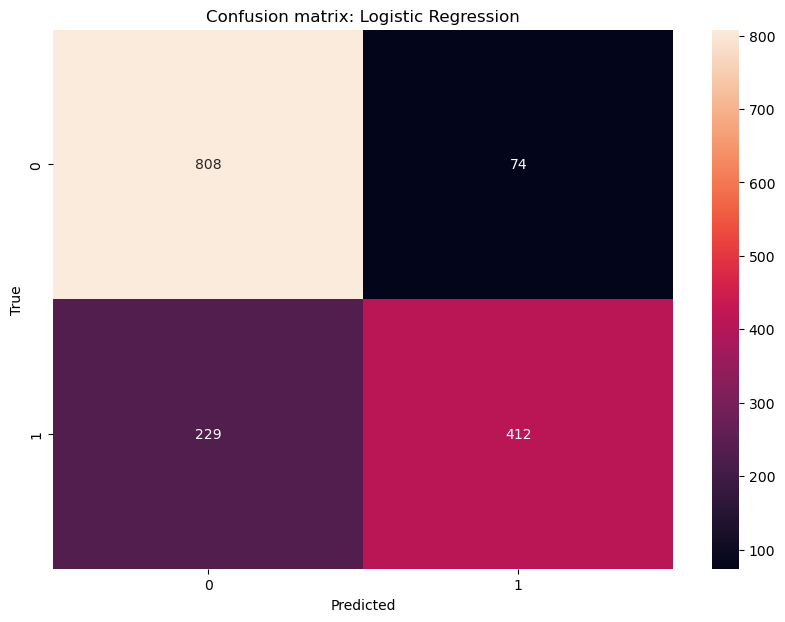

In [46]:
print("f1_score : ", metrics.f1_score(y_test, y1_pred))
print('Area under curve: ', sklearn.metrics.roc_auc_score(y_test, y1_pred))

cm = confusion_matrix(y_test, y1_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix: Logistic Regression')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()